In [3]:
%load_ext autoreload
%autoreload

In [4]:
from curvemetrics.datafetcher import DataFetcher
from curvemetrics.metricsprocessor import MetricsProcessor
import timeit
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from web3 import Web3
import matplotlib.pyplot as plt
from curvemetrics.datahandler import DataHandler
import json
from curvemetrics.queries import queries
import ccxt
from dotenv import load_dotenv
import os
from scipy.optimize import minimize

In [5]:
datahandler = DataHandler()
token_metadata = datahandler.get_token_metadata()
pool_metadata = datahandler.get_pool_metadata()
pool = "0xceaf7747579696a2f0bb206a14210e3c9e6fb269" # Curve.fi Factory USD Metapool: wormhole v2 UST-3Pool
ust = "0xa693b19d2931d498c5b318df961919bb4aee87a5"
start = datetime.timestamp(datetime(2022, 1, 1))
end=datetime.timestamp(datetime(2022, 6, 1))
STEP = '6h'

Executing: SELECT * FROM tokens...
Executing: SELECT * FROM pools...


In [6]:
swaps_data = datahandler.get_swaps_data(pool, start, end)
swaps_data.head()

Executing: SELECT * FROM swaps WHERE pool_id=? AND timestamp >= ? AND timestamp <= ? ORDER BY timestamp ASC...


,id,timestamp,tx,pool_id,amountBought,amountSold,tokenBought,tokenSold,buyer,gasLimit,gasUsed,isUnderlying,block_gte,block_lt,block
0,0x38c995935dd7bac29353c2846e48990a8962818e91b8...,1641012694,0x38c995935dd7bac29353c2846e48990a8962818e91b8...,0xceaf7747579696a2f0bb206a14210e3c9e6fb269,1.557014e+06,1.557870e+06,0xa693b19d2931d498c5b318df961919bb4aee87a5,0xdac17f958d2ee523a2206206994597c13d831ec7,0xa00b0540f43e00a634d016a31b0a39d95170e6bf,420696,278825,1,13917486,13917496,13917492
1,0x5a1b61d6b5bb372778d184f63ab8138cc95f77e00c18...,1641015080,0x5a1b61d6b5bb372778d184f63ab8138cc95f77e00c18...,0xceaf7747579696a2f0bb206a14210e3c9e6fb269,9.015130e+04,9.021758e+04,0xa693b19d2931d498c5b318df961919bb4aee87a5,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xdf388f1155e621e21764988289def81da92f3284,3034083,644328,1,13917646,13917656,13917651
2,0xcbced056e6a1c80d9233e0fb385ec9e8400264b0ad08...,1641015189,0xcbced056e6a1c80d9233e0fb385ec9e8400264b0ad08...,0xceaf7747579696a2f0bb206a14210e3c9e6fb269,8.796879e+04,8.803422e+04,0xa693b19d2931d498c5b318df961919bb4aee87a5,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xdf388f1155e621e21764988289def81da92f3284,3028180,644350,1,13917656,13917666,13917658
3,0x8f9e535b4849f4e17fdccf25345a0cb971896aa7e8b3...,1641015209,0x8f9e535b4849f4e17fdccf25345a0cb971896aa7e8b3...,0xceaf7747579696a2f0bb206a14210e3c9e6fb269,9.170069e+04,9.176966e+04,0xa693b19d2931d498c5b318df961919bb4aee87a5,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xa10fca31a2cb432c9ac976779dc947cfdb003ef0,560373,387728,1,13917656,13917666,13917659
4,0x0ffc54cca22ade765ba0f30c6cc83e6fc49509e86451...,1641022410,0x0ffc54cca22ade765ba0f30c6cc83e6fc49509e86451...,0xceaf7747579696a2f0bb206a14210e3c9e6fb269,6.621675e+04,6.623862e+04,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xa693b19d2931d498c5b318df961919bb4aee87a5,0xdf388f1155e621e21764988289def81da92f3284,3075147,624930,1,13918196,13918206,13918197


In [196]:
ust_trades = swaps_data.copy()
ust_trades['Buy'] = (ust_trades['tokenBought'] == ust)
ust_trades['Sell'] = (ust_trades['tokenSold'] == ust)
ust_trades['timestamp'] = ust_trades['timestamp'].apply(datetime.fromtimestamp)
ust_trades = ust_trades.set_index('timestamp')
ust_trades = ust_trades.resample(STEP).agg({'Buy': 'sum', 'Sell': 'sum'})
ust_trades.head()

,Buy,Sell
timestamp,,
2022-01-01 00:00:00,1.826835e+06,0.000000
2022-01-01 06:00:00,1.019093e+06,313312.306264
2022-01-01 12:00:00,0.000000e+00,90554.667537
2022-01-01 18:00:00,0.000000e+00,137804.586797
2022-01-02 00:00:00,0.000000e+00,63970.196798


In [1]:
# initialize parameters for PIN estimations
def init_pin_params(df):
    avg_B = df['Buy'].mean()
    avg_S = df['Sell'].mean()
    alph = 0.1
    delt = 0.3
    gamm = 0.5
    B_bar = avg_B
    epsiB = gamm*B_bar
    miu = (B_bar-epsiB)/(alph*(1-delt))
    epsiS = avg_S-alph*delt*miu
    return [alph,delt,miu,epsiB,epsiS]

# def pin_likelihood_EHO(params, df): 
#     #initialize parameter values
#     alph, delt, mu, epsiB, epsiS = params

#     # Constraints from the model
#     if any(x < 0 for x in params) or alph > 1 or delt > 1:
#         return np.inf

#     def likelihood(row):
#         #number of buy- and sell-trades for the trading day
#         buy_s = row['Buy']
#         sell_s = row['Sell']

#         # Avoid invalid computations
#         if mu <= 0 or epsiB <= 0 or epsiS <= 0:
#             return np.inf

#         #compute values of interest for the log-likelihood function
#         M  = int(min(buy_s,sell_s)+max(buy_s,sell_s)/2)
#         Xs = epsiS/(mu+epsiS)
#         Xb = epsiB/(mu+epsiB)

#         a1 = np.exp(-mu)
#         a2 = Xs**(sell_s-M) if sell_s-M >= 0 else 0
#         a3 = Xb**(buy_s-M) if buy_s-M >= 0 else 0
#         a4 = Xs**(-M) if M >= 0 else 0
#         a5 = Xb**(-M) if M >= 0 else 0

#         # Avoid NaN and Inf in logarithmic operations
#         if any(x <= 0 for x in [Xb, Xs, mu+epsiB, mu+epsiS, a1*a2*a5, a1*a3*a4, a2*a3]):
#             return np.inf

#         part1 = -epsiB-epsiS+M*(np.log(Xb)+np.log(Xs))+buy_s*np.log(mu+epsiB)+sell_s*np.log(mu+epsiS)
#         part2 = np.log(alph*(1-delt)*a1*a2*a5+alph*delt*a1*a3*a4+(1-alph)*a2*a3)

#         return part1+part2

#     return -1 * df.apply(likelihood, axis=1).sum()

def pin_likelihood_LK(params, df):
    '''
    Estimate joint likelihood function using factorization from Lin and Ke(2011)
    
    @Params
        params (tuple): \alpha, \delta \mu, \epsilon_B, \epsilon_S 
        df (pd.DataFrame): timeseries DataFrame with Buy and Sell columns
    
    @Returns
        likelihood (float): joint likelihood function, the likelihood of the params given the buy and sell flow
    
    @Credit: modified from https://github.com/shuangology/Probability-of-Informed-Trading/tree/master 
        by shuangology
    '''
    #initialize parameter values
    alph, delt, mu, epsiB, epsiS = params

    def likelihood(row):
        buy_s = row['Buy']
        sell_s = row['Sell']
        
        #compute values of interest for the log-likelihood function
        e1 = -mu-sell_s*np.log(1+mu/epsiS)
        e2 = -mu-buy_s*np.log(1+mu/epsiB)
        e3 = -buy_s*np.log(1+mu/epsiB)-sell_s*np.log(1+mu/epsiS)
        e_m = max(e1,e2,e3)
        
        part1 = -epsiB-epsiS+buy_s*np.log(mu+epsiB)+sell_s*np.log(mu+epsiS)+e_m
        part2 = np.log(alph*(1-delt)*np.exp(e1-e_m)+alph*delt*np.exp(e2-e_m)+(1-alph)*np.exp(e3-e_m))
    
        return part1+part2

    return -1 * df.apply(likelihood, axis=1).sum()

def _pin(params):
    alph,delt,mu,epsiB,epsiS = params
    return (alph*mu)/(alph*mu+epsiB+epsiS)

# an example for estimating PIN value use both methods on a 30 day window
def pin(df):
    initial_params = init_pin_params(df)
    opt_params = minimize(pin_likelihood_LK, initial_params, args = (df),method = 'Nelder-Mead').x
    return _pin(opt_params)

In [2]:
def rolling_apply(df, delta=timedelta(days=1)):
    curr = df.index[0]
    end = df.index[-1]
    while curr <= end - delta:
        print(curr, curr+delta)
        df.loc[curr+delta, "PIN"] = pin(df.loc[curr:curr+delta])
        curr += timedelta(hours=6) # TODO: Fix this with the actual step size  
    return df

NameError: name 'timedelta' is not defined

In [199]:
foo = ust_trades.loc['2022-05-01':'2022-05-20']
foo = rolling_apply(foo)
foo.tail()

2022-05-01 00:00:00 2022-05-02 00:00:00


/tmp/ipykernel_182417/2500834221.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[curr+delta, "PIN"] = minimize_PIN(df.loc[curr:curr+delta], method=method)
/tmp/ipykernel_182417/3843951311.py:62: RuntimeWarning: invalid value encountered in log
  e1 = -mu-sell_s*np.log(1+mu/epsiS)
/tmp/ipykernel_182417/3843951311.py:64: RuntimeWarning: invalid value encountered in log
  e3 = -buy_s*np.log(1+mu/epsiB)-sell_s*np.log(1+mu/epsiS)


2022-05-01 06:00:00 2022-05-02 06:00:00
2022-05-01 12:00:00 2022-05-02 12:00:00
2022-05-01 18:00:00 2022-05-02 18:00:00
2022-05-02 00:00:00 2022-05-03 00:00:00


/tmp/ipykernel_182417/3843951311.py:68: RuntimeWarning: invalid value encountered in log
  part2 = np.log(alph*(1-delt)*np.exp(e1-e_m)+alph*delt*np.exp(e2-e_m)+(1-alph)*np.exp(e3-e_m))


2022-05-02 06:00:00 2022-05-03 06:00:00
2022-05-02 12:00:00 2022-05-03 12:00:00
2022-05-02 18:00:00 2022-05-03 18:00:00
2022-05-03 00:00:00 2022-05-04 00:00:00
2022-05-03 06:00:00 2022-05-04 06:00:00
2022-05-03 12:00:00 2022-05-04 12:00:00
2022-05-03 18:00:00 2022-05-04 18:00:00
2022-05-04 00:00:00 2022-05-05 00:00:00
2022-05-04 06:00:00 2022-05-05 06:00:00
2022-05-04 12:00:00 2022-05-05 12:00:00


/tmp/ipykernel_182417/3843951311.py:63: RuntimeWarning: invalid value encountered in log
  e2 = -mu-buy_s*np.log(1+mu/epsiB)
/tmp/ipykernel_182417/3843951311.py:67: RuntimeWarning: invalid value encountered in log
  part1 = -epsiB-epsiS+buy_s*np.log(mu+epsiB)+sell_s*np.log(mu+epsiS)+e_m


2022-05-04 18:00:00 2022-05-05 18:00:00
2022-05-05 00:00:00 2022-05-06 00:00:00
2022-05-05 06:00:00 2022-05-06 06:00:00
2022-05-05 12:00:00 2022-05-06 12:00:00
2022-05-05 18:00:00 2022-05-06 18:00:00
2022-05-06 00:00:00 2022-05-07 00:00:00
2022-05-06 06:00:00 2022-05-07 06:00:00
2022-05-06 12:00:00 2022-05-07 12:00:00
2022-05-06 18:00:00 2022-05-07 18:00:00
2022-05-07 00:00:00 2022-05-08 00:00:00
2022-05-07 06:00:00 2022-05-08 06:00:00
2022-05-07 12:00:00 2022-05-08 12:00:00
2022-05-07 18:00:00 2022-05-08 18:00:00
2022-05-08 00:00:00 2022-05-09 00:00:00
2022-05-08 06:00:00 2022-05-09 06:00:00
2022-05-08 12:00:00 2022-05-09 12:00:00
2022-05-08 18:00:00 2022-05-09 18:00:00
2022-05-09 00:00:00 2022-05-10 00:00:00
2022-05-09 06:00:00 2022-05-10 06:00:00
2022-05-09 12:00:00 2022-05-10 12:00:00
2022-05-09 18:00:00 2022-05-10 18:00:00
2022-05-10 00:00:00 2022-05-11 00:00:00
2022-05-10 06:00:00 2022-05-11 06:00:00
2022-05-10 12:00:00 2022-05-11 12:00:00
2022-05-10 18:00:00 2022-05-11 18:00:00


,Buy,Sell,PIN
timestamp,,,
2022-05-19 18:00:00,1.224737e+06,1.160391e+06,0.191392
2022-05-20 00:00:00,2.101163e+05,2.606664e+05,0.245246
2022-05-20 06:00:00,6.795025e+05,1.161277e+06,0.355277
2022-05-20 12:00:00,1.202827e+06,1.811624e+06,0.059072
2022-05-20 18:00:00,2.964240e+06,2.680248e+06,0.177438


In [200]:
token_ohlcv = datahandler.get_ohlcv_data(ust, start, end)
token_ohlcv = token_ohlcv.loc['2022-05-01':'2022-05-20'].resample(STEP).last()

Executing: SELECT * FROM token_ohlcv WHERE token_id=? AND timestamp >= ? AND timestamp <= ? ORDER BY timestamp ASC...
Executing: SELECT * FROM token_ohlcv WHERE token_id=? AND timestamp >= ? AND timestamp <= ? ORDER BY timestamp ASC...
Executing: SELECT * FROM token_ohlcv WHERE token_id=? AND timestamp >= ? AND timestamp <= ? ORDER BY timestamp ASC...
Executing: SELECT * FROM token_ohlcv WHERE token_id=? AND timestamp >= ? AND timestamp <= ? ORDER BY timestamp ASC...
Executing: SELECT * FROM token_ohlcv WHERE token_id=? AND timestamp >= ? AND timestamp <= ? ORDER BY timestamp ASC...


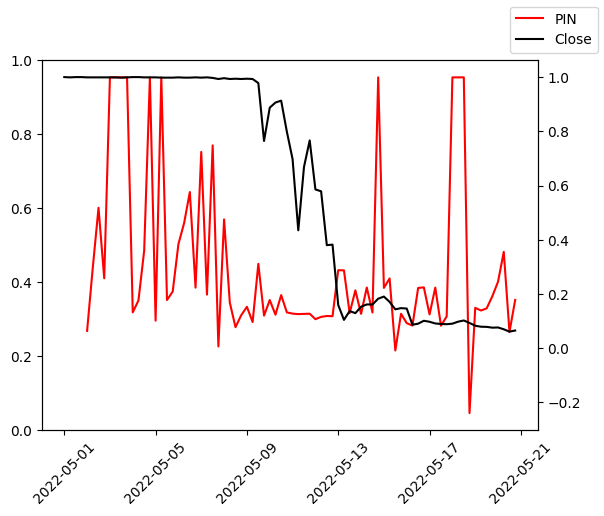

In [201]:
f, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax2.plot(foo.index, foo['PIN'], label='PIN', color='red')
ax2.plot(foo.index, token_ohlcv['close'], label='Close', color='black')
f.legend()
ax1.tick_params(axis='x', rotation=45)
plt.show()

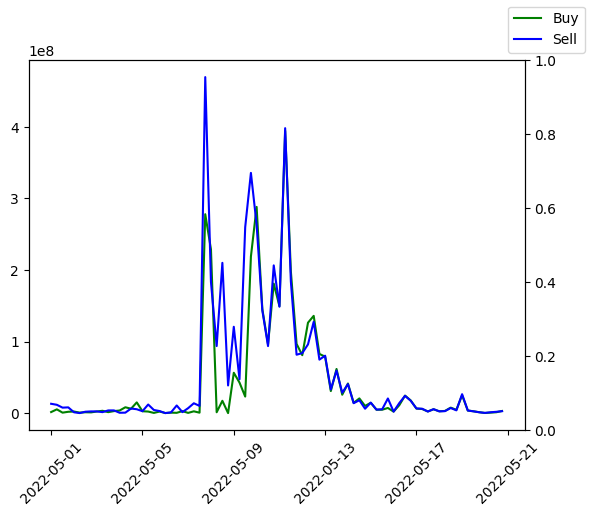

In [202]:
f, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(foo.index, foo['Buy'], label='Buy', color='green')
ax1.plot(foo.index, foo['Sell'], label='Sell', color='blue')
f.legend()
ax1.tick_params(axis='x', rotation=45)
plt.show()